# Tratamiento de ruido de clase

Cargamos un data set de ejemplo, como iris, e intentamos limpiar el ruido de una partición de training (con un hold-out 80-20%). Desconocemos el nivel de ruido original, por lo que veremos qué limpian los diferentes métodos tratamiento de ruido de clase.

In [12]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


iris = load_iris()
iris_train_x, iris_test_x, iris_train_y, iris_test_y = train_test_split(iris.data, iris.target, test_size=0.2)

iris_train_x.shape, iris_train_y.shape, iris_test_x.shape, iris_test_y.shape

((120, 4), (120,), (30, 4), (30,))

## Ensemble filter

1. For each learning algorithm, a k-fold cross-validation is used to tag each training example as correct (prediction = training data label) or mislabeled (prediction ≠ training data label).
2. A voting scheme is used to identify the final set of noisy examples.
    - Consensus voting: it removes an example if it is misclassified by all the classifiers.
    - Majority voting: it removes an instance if it is misclassified by more than half of the classifiers.


In [72]:
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np

def EnsembleFilter(X, y, k=5, voting='consensus'):
    """
    Apply the Ensemble Filter to detect and remove noisy examples from the training data.

    Parameters:
    - X: numpy array of shape (n_samples, n_features), the training data.
    - y: numpy array of shape (n_samples,), the training labels.
    - k: int, number of folds for cross-validation.
    - voting: str, either 'consensus' or 'majority' voting scheme.

    Returns:
    - clean_X: numpy array of shape (n_clean_samples, n_features), the filtered training data.
    - clean_y: numpy array of shape (n_clean_samples,), the filtered training labels.
    """
    
    # Initialize classifiers
    classifiers = [
        DecisionTreeClassifier(),          # C4.5 equivalent
        KNeighborsClassifier(n_neighbors=1), # 1-NN
        LinearDiscriminantAnalysis()       # LDA
    ]

    # Perform k-fold cross-validation
    kf = KFold(n_splits=k, shuffle=True, random_state=0)
    mislabel_counts = np.zeros(len(y))

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Train each classifier and make predictions
        for clf in classifiers:
            clf.fit(X_train, y_train)
            predictions = clf.predict(X_test)
            mislabel_counts[test_index] += (predictions != y_test)  # Increment mislabel count for misclassified samples

    # Determine which examples to keep based on voting scheme
    if voting == 'consensus':
        # Consensus voting: retain examples misclassified by all classifiers
        noisy_indices = np.where(mislabel_counts == len(classifiers))[0]
    elif voting == 'majority':
        # Majority voting: retain examples misclassified by more than half of classifiers
        noisy_indices = np.where(mislabel_counts > len(classifiers) / 2)[0]
    else:
        raise ValueError("Voting must be either 'consensus' or 'majority'")

    # Filter out noisy examples
    clean_indices = np.setdiff1d(np.arange(len(y)), noisy_indices)
    clean_X = X[clean_indices]
    clean_y = y[clean_indices]

    return clean_X, clean_y


In [73]:
iris_train_clean_x, iris_train_clean_y = EnsembleFilter(iris_train_x, iris_train_y, k=5, voting='consensus')

#Comprobamos si se han filtrado algunas instancias
iris_train_x.shape, iris_train_y.shape,iris_train_clean_x.shape, iris_train_clean_y.shape

((120, 4), (120,), (117, 4), (117,))

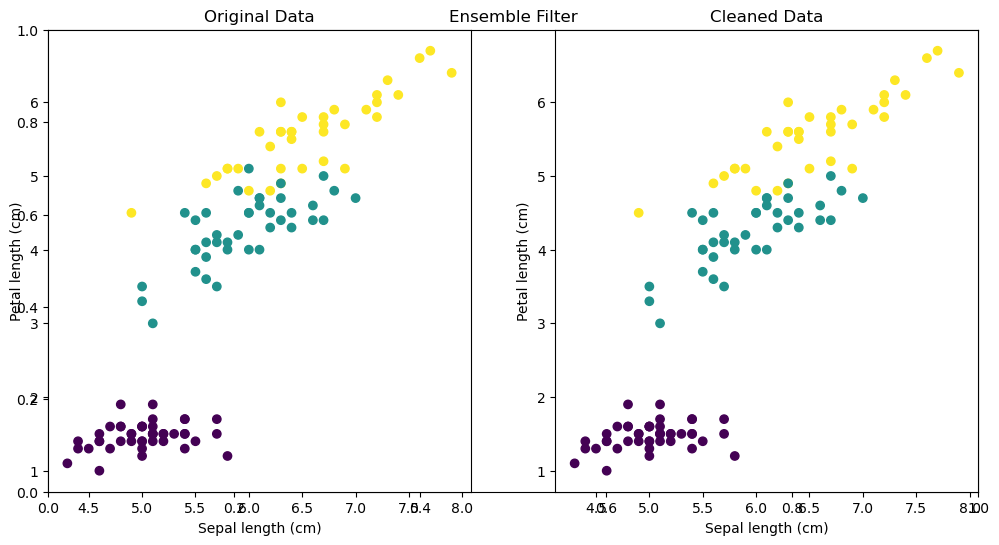

In [74]:
#imprimir los datos limpios con sepal length (cm) y petal length (cm) coloreando por etiqueta lado a lado

plt.figure(figsize=(12, 6))
plt.title("Ensemble Filter")
plt.subplot(1, 2, 1)
plt.scatter(iris_train_x[:, 0], iris_train_x[:, 2], c=iris_train_y)
plt.title("Original Data")
plt.xlabel("Sepal length (cm)")
plt.ylabel("Petal length (cm)")
plt.subplot(1, 2, 2)
plt.scatter(iris_train_clean_x[:, 0], iris_train_clean_x[:, 2], c=iris_train_clean_y)
plt.title("Cleaned Data")
plt.xlabel("Sepal length (cm)")
plt.ylabel("Petal length (cm)")
plt.show()


## Cross-Validated Committees Filter (CVCF)

In [75]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold

def CVCF(X, y, k=5):
    """
    Apply CVCF to detect and remove noisy examples from the training data using Decision Trees.

    Parameters:
    - X: numpy array of shape (n_samples, n_features), the training data.
    - y: numpy array of shape (n_samples,), the training labels.
    - k: int, number of folds for cross-validation.

    Returns:
    - clean_X: numpy array of shape (n_clean_samples, n_features), the filtered training data.
    - clean_y: numpy array of shape (n_clean_samples,), the filtered training labels.
    """
    
    # Initialize classifier (C4.5 equivalent)
    classifier = DecisionTreeClassifier()

    # Perform k-fold cross-validation
    kf = KFold(n_splits=k, shuffle=True, random_state=0)
    mislabel_counts = np.zeros(len(y))

    # Loop through each fold
    for train_index, _ in kf.split(X):
        X_train, y_train = X[train_index], y[train_index]

        # Train the classifier
        classifier.fit(X_train, y_train)

        # Predict on all training examples
        predictions = classifier.predict(X)

        # Count mislabeling
        mislabel_counts += (predictions != y)  # Increment mislabel count for misclassified samples

    # Identify noisy examples
    noisy_indices = np.where(mislabel_counts > 0)[0]  # Identify examples misclassified at least once

    # Filter out noisy examples
    clean_indices = np.setdiff1d(np.arange(len(y)), noisy_indices)
    clean_X = X[clean_indices]
    clean_y = y[clean_indices]

    return clean_X, clean_y


In [76]:
iris_train_clean_x, iris_train_clean_y = CVCF(iris_train_x, iris_train_y, k=5)

#Comprobamos si se han filtrado algunas instancias
iris_train_x.shape, iris_train_y.shape,iris_train_clean_x.shape, iris_train_clean_y.shape

((120, 4), (120,), (110, 4), (110,))

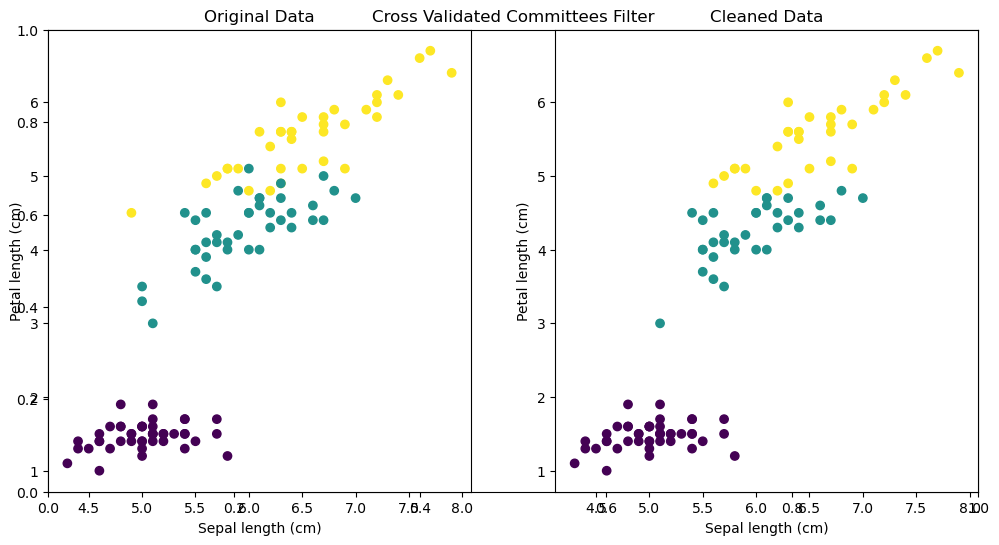

In [77]:
#imprimir los datos limpios con sepal length (cm) y petal length (cm) coloreando por etiqueta lado a lado

plt.figure(figsize=(12, 6))
plt.title("Cross Validated Committees Filter")
plt.subplot(1, 2, 1)
plt.scatter(iris_train_x[:, 0], iris_train_x[:, 2], c=iris_train_y)
plt.title("Original Data")
plt.xlabel("Sepal length (cm)")
plt.ylabel("Petal length (cm)")
plt.subplot(1, 2, 2)
plt.scatter(iris_train_clean_x[:, 0], iris_train_clean_x[:, 2], c=iris_train_clean_y)
plt.title("Cleaned Data")
plt.xlabel("Sepal length (cm)")
plt.ylabel("Petal length (cm)")
plt.show()


# Iterative Partitioning Filter

In [78]:
def IPF(X, y, k=5, percentage_threshold=0.1, max_iterations=100):
    """
    Apply the Iterative Partitioning Filter (IPF) to remove noisy data.

    Parameters:
    - X: numpy array of shape (n_samples, n_features), the training data.
    - y: numpy array of shape (n_samples,), the training labels.
    - k: int, number of folds for cross-validation in CVCF.
    - percentage_threshold: float, the threshold percentage of the size of the training dataset
      to determine if the number of noisy examples is acceptable.
    - max_iterations: int, maximum number of iterations to perform.

    Returns:
    - clean_X: numpy array of shape (n_clean_samples, n_features), the filtered training data.
    - clean_y: numpy array of shape (n_clean_samples,), the filtered training labels.
    
    Requires:
    - CVCF: function that applies the Cross-Validated Committees Filter.
    """
    num_samples = len(y)
    noisy_count = num_samples
    consecutive_noisy_iterations = 0
    prev_noisy_count = noisy_count

    for iteration in range(max_iterations):
        clean_X, clean_y = CVCF(X, y, k)

        # Calculate the number of noisy examples
        noisy_count = num_samples - len(clean_y)

        # Check for stopping criterion
        if noisy_count < percentage_threshold * num_samples:
            consecutive_noisy_iterations += 1
        else:
            consecutive_noisy_iterations = 0

        if consecutive_noisy_iterations >= 3:  # Stop if the last 3 iterations have acceptable noisy counts
            break

        # Update X and y for the next iteration
        X, y = clean_X, clean_y

    return clean_X, clean_y

In [79]:
iris_train_clean_x, iris_train_clean_y = IPF(iris_train_x, iris_train_y, k=5)

#Comprobamos si se han filtrado algunas instancias
iris_train_x.shape, iris_train_y.shape,iris_train_clean_x.shape, iris_train_clean_y.shape

((120, 4), (120,), (109, 4), (109,))

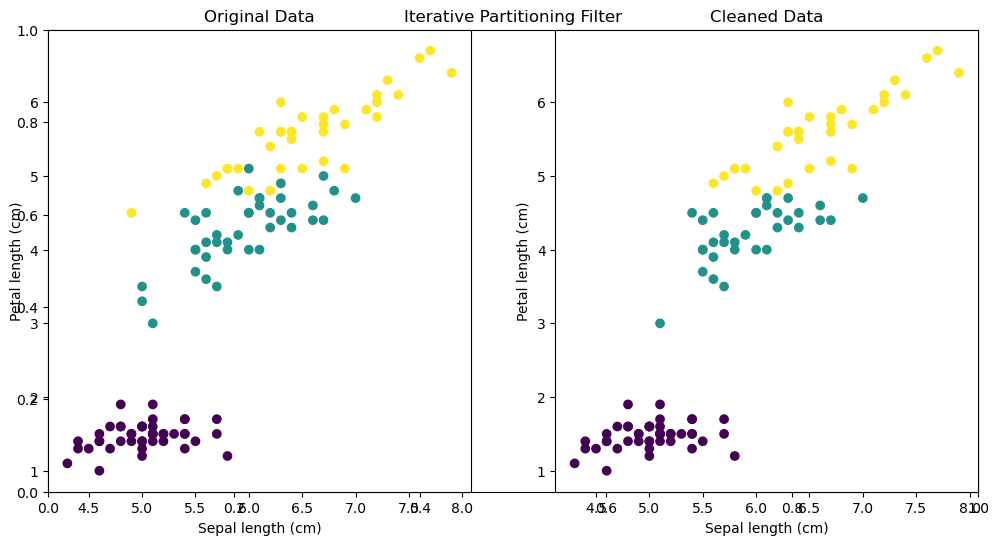

In [80]:
#imprimir los datos limpios con sepal length (cm) y petal length (cm) coloreando por etiqueta lado a lado

plt.figure(figsize=(12, 6))
plt.title("Iterative Partitioning Filter")
plt.subplot(1, 2, 1)
plt.scatter(iris_train_x[:, 0], iris_train_x[:, 2], c=iris_train_y)
plt.title("Original Data")
plt.xlabel("Sepal length (cm)")
plt.ylabel("Petal length (cm)")
plt.subplot(1, 2, 2)
plt.scatter(iris_train_clean_x[:, 0], iris_train_clean_x[:, 2], c=iris_train_clean_y)
plt.title("Cleaned Data")
plt.xlabel("Sepal length (cm)")
plt.ylabel("Petal length (cm)")
plt.show()

# Outlier Detection

Como hemos visto en otras asignaturas, el objetivo de la detección de anomalías es encontrar ejemplos (muestras) que son extrañas. 

Podemos utilizar detectores de outliers para filtrar ruido, aunque su propósito no sea ese.



## Detección Outliers usando scikit-learn

`Scikit-learn` ofrece distintos algoritmos para detectar *outliers* [En la Documentación](https://scikit-learn.org/stable/modules/outlier_detection.html?highlight=outliers)

![](outliers.png)

Vamos a probar *Isolation Forest*.

## *Isolation Forest*

'Aisla' observaciones aleatoriamente escogiendo una característica y
aleatoriamente divide recursivamente según sus valores, usando una estructura de
árbol.

Cerca de -1 si lo considera *outlier*, 1 en caso contrario.

In [ ]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(n_estimators=10, warm_start=True)
clf.fit(iris_train_x)  # fit 10 trees

# Predecir outliers
outlier_predictions = clf.predict(iris_train_x)  # -1 para outliers, 1 para inliers

# Crear un DataFrame a partir del array NumPy
X_df_if = pd.DataFrame(iris_train_x, columns=iris.feature_names)

# Añadir columna de outliers al DataFrame (True para outliers, False para inliers)
X_df_if["outlier"] = outlier_predictions < 1  # Cambia a True si es outlier

# Mostrar las primeras filas del DataFrame
print(X_df_if.head(3))

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.7               3.8                1.7               0.3   
1                5.5               2.6                4.4               1.2   
2                5.8               2.7                3.9               1.2   

   outlier  
0     True  
1    False  
2    False  


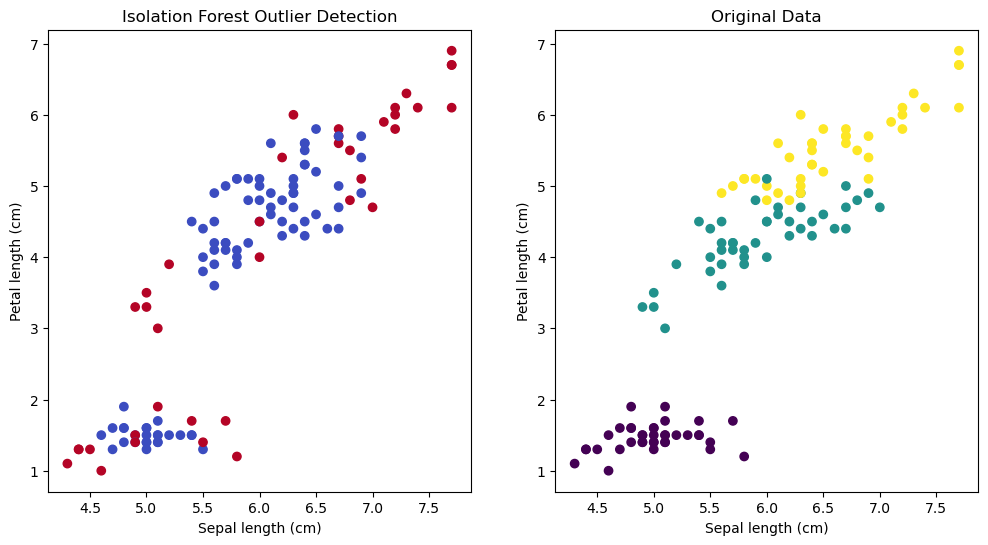

In [ ]:
# pintamos x_df_if
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_df_if["sepal length (cm)"], X_df_if["petal length (cm)"], c=X_df_if["outlier"], cmap='coolwarm')
plt.title("Isolation Forest Outlier Detection")
plt.xlabel("Sepal length (cm)")
plt.ylabel("Petal length (cm)")
plt.subplot(1, 2, 2)
plt.scatter(iris_train_x[:, 0], iris_train_x[:, 2], c=iris_train_y)
plt.title("Original Data")
plt.xlabel("Sepal length (cm)")
plt.ylabel("Petal length (cm)")
plt.show()


## *LocalOutlierFactor*

Esta técnica mide la desviación local de una muestra respecto a los vecinos
(usando k-vecinos). Al comparar la distancia local con la de los vecinos, se
ientifica las instancias con una densidad sustanciamente menor que sus vecinos.

Cerca de -1 si lo considera *outlier*, 1 en caso contrario.

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=10)

iris_df = pd.DataFrame(iris_train_x, columns=iris.feature_names)
iris_df_loc = iris_df.copy()
iris_df_loc["outlier"] = np.abs(clf.fit_predict(iris_df) - -1) <= 1e-3
print(iris_df_loc.head(3))

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.4               3.7                1.5               0.2   
1                5.7               2.6                3.5               1.0   
2                7.7               3.0                6.1               2.3   

   outlier  
0    False  
1    False  
2    False  


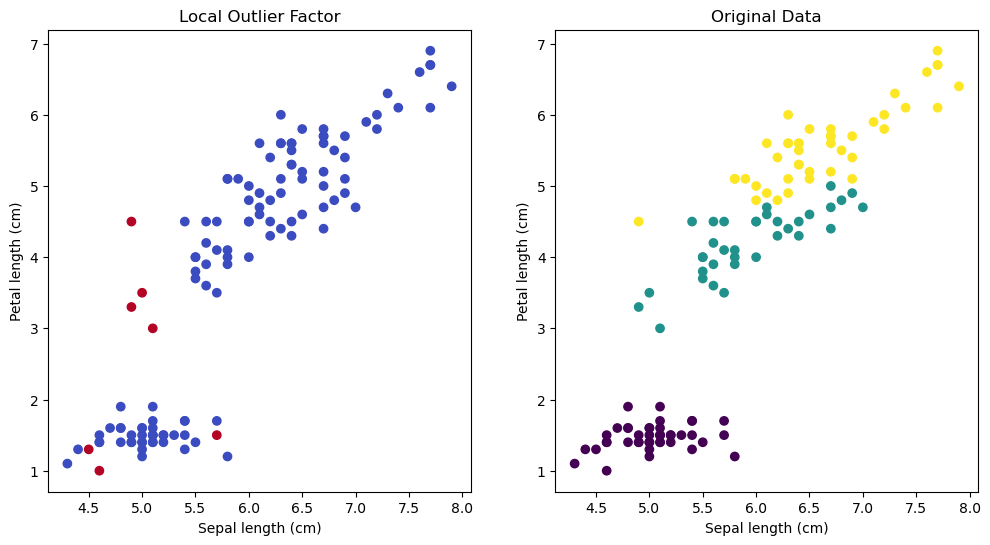

In [ ]:
# pintamos x_df_loc
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(iris_df_loc["sepal length (cm)"], iris_df_loc["petal length (cm)"], c=iris_df_loc["outlier"], cmap='coolwarm')
plt.title("Local Outlier Factor")
plt.xlabel("Sepal length (cm)")
plt.ylabel("Petal length (cm)")
plt.subplot(1, 2, 2)
plt.scatter(iris_train_x[:, 0], iris_train_x[:, 2], c=iris_train_y)
plt.title("Original Data")
plt.xlabel("Sepal length (cm)")
plt.ylabel("Petal length (cm)")
plt.show()


## Detección de anomalías con PyOD

Una biblioteca muy potente en Python para la detección de outliers con métodos no paramétricos es PyOD (https://pyod.readthedocs.io/en/latest/).

Vamos a utilizar KNN para detectar outliers sobre el conjunto completo.

Text(0, 0.5, 'Petal Length (cm)')

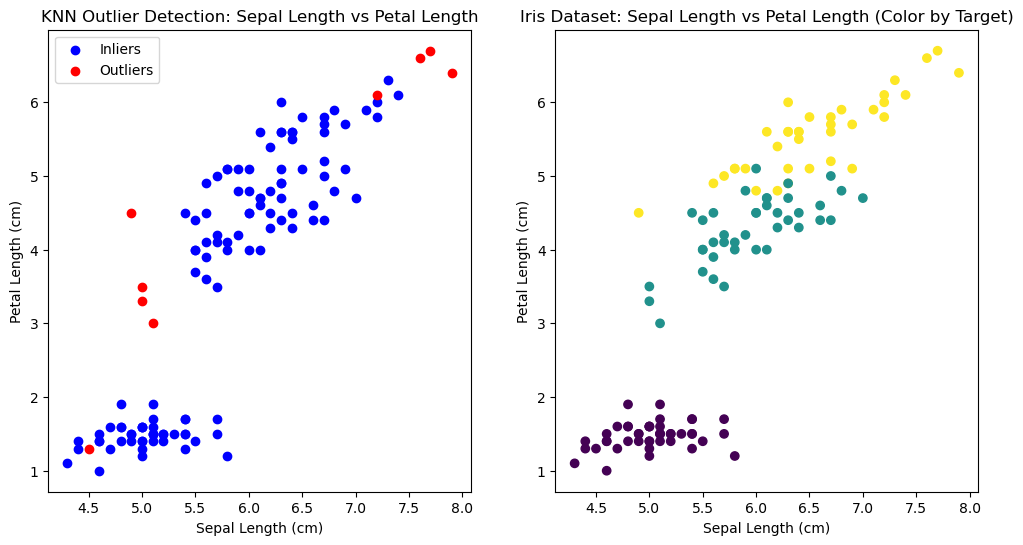

In [81]:
from pyod.models.knn import KNN

clf = KNN()
clf.fit(iris_train_x)
outliers = clf.predict(iris_train_x)

# Scatter plot of inliers (0) and outliers (1)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(iris_train_x[outliers == 0, 0],  # sepal length
            iris_train_x[outliers == 0, 2],  # petal length
            color='blue', label='Inliers')
plt.scatter(iris_train_x[outliers == 1, 0],  # sepal length
            iris_train_x[outliers == 1, 2],  # petal length
            color='red', label='Outliers')
plt.title('KNN Outlier Detection: Sepal Length vs Petal Length')
plt.xlabel('Sepal Length (cm)')
plt.ylabel('Petal Length (cm)')
plt.legend()

# Plot with color coding based on the target labels
plt.subplot(1, 2, 2)
plt.scatter(iris_train_x[:, 0],  # sepal length
            iris_train_x[:, 2],  # petal length
            c=iris_train_y, cmap='viridis', label='Target Label')
plt.title('Iris Dataset: Sepal Length vs Petal Length (Color by Target)')
plt.xlabel('Sepal Length (cm)')
plt.ylabel('Petal Length (cm)')

## Detección de anomalías por clase para detectar ruido

Podemos observar que los valores detectados como outliers son aquellos que se encuentran más separados, pero no necesariamente son los más conflictivos en las fronteras de decisión.

Vamos a realizar la detección por clase.

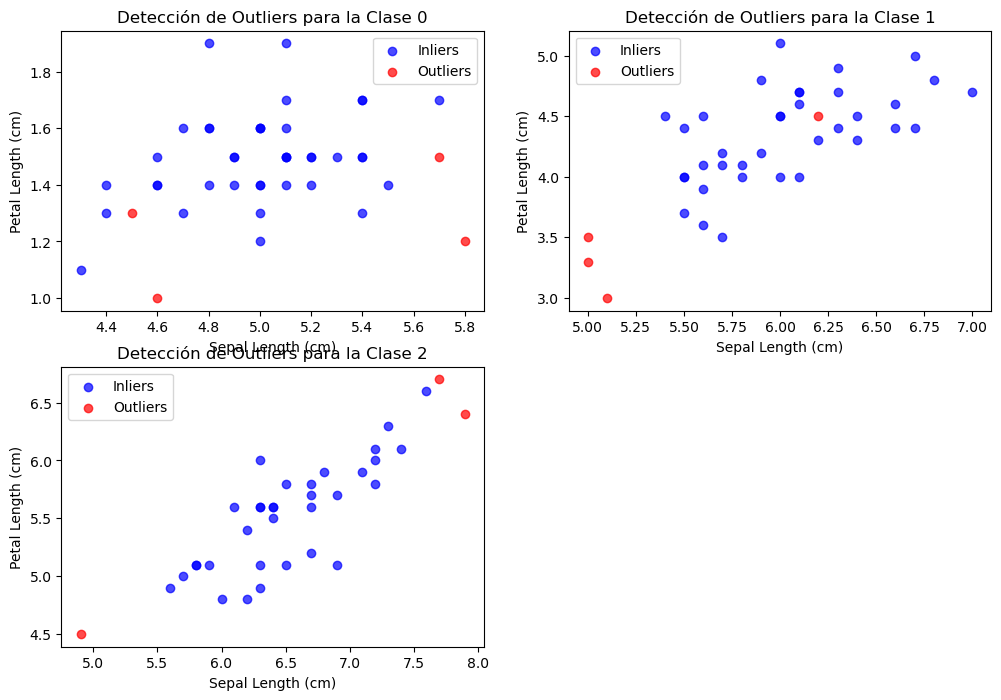

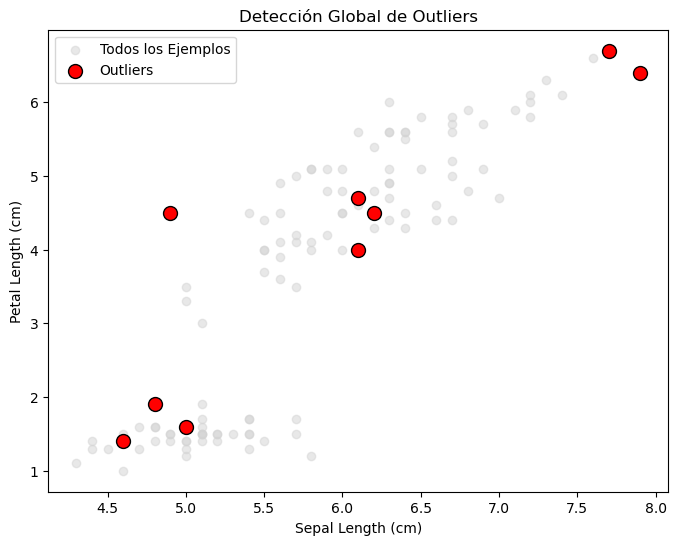

Nuevo conjunto sin outliers:
[[5.7 2.6 3.5 1. ]
 [4.8 3.1 1.6 0.2]
 [5.9 3.2 4.8 1.8]
 [6.7 3.  5.  1.7]
 [6.6 2.9 4.6 1.3]
 [5.7 4.4 1.5 0.4]
 [5.2 3.5 1.5 0.2]
 [5.4 3.9 1.3 0.4]
 [5.1 3.5 1.4 0.3]
 [6.  3.4 4.5 1.6]
 [5.4 3.  4.5 1.5]
 [5.5 2.6 4.4 1.2]
 [5.4 3.9 1.7 0.4]
 [5.8 4.  1.2 0.2]
 [5.1 3.8 1.5 0.3]
 [6.6 3.  4.4 1.4]
 [6.3 3.3 6.  2.5]
 [5.  2.  3.5 1. ]
 [4.9 3.1 1.5 0.1]
 [5.8 2.7 4.1 1. ]
 [6.2 2.8 4.8 1.8]
 [5.9 3.  4.2 1.5]
 [6.4 3.1 5.5 1.8]
 [5.4 3.4 1.5 0.4]
 [4.6 3.6 1.  0.2]
 [5.6 2.8 4.9 2. ]
 [6.1 3.  4.6 1.4]
 [6.2 2.9 4.3 1.3]
 [5.5 2.4 3.7 1. ]
 [5.9 3.  5.1 1.8]
 [6.7 3.1 4.4 1.4]
 [6.3 2.3 4.4 1.3]
 [7.  3.2 4.7 1.4]
 [6.8 3.2 5.9 2.3]
 [6.1 2.6 5.6 1.4]
 [6.8 2.8 4.8 1.4]
 [5.  3.6 1.4 0.2]
 [5.1 3.4 1.5 0.2]
 [4.8 3.4 1.6 0.2]
 [5.  3.5 1.3 0.3]
 [5.  3.4 1.6 0.4]
 [5.8 2.8 5.1 2.4]
 [6.3 2.8 5.1 1.5]
 [4.7 3.2 1.3 0.2]
 [6.  3.  4.8 1.8]
 [4.9 3.  1.4 0.2]
 [7.4 2.8 6.1 1.9]
 [5.6 3.  4.1 1.3]
 [5.  2.3 3.3 1. ]
 [5.8 2.6 4.  1.2]
 [5.4 3.4 1.7 0.2]
 [

In [82]:
# Inicializar el gráfico
plt.figure(figsize=(12, 8))

# Almacenar todos los índices de outliers
all_outliers_indices = []

# Obtener las clases únicas
classes = np.unique(iris_train_y)

for cls in classes:
    # Filtrar los datos por clase
    X_class = iris_train_x[iris_train_y == cls]

    # Ajustar el modelo KNN para la clase actual
    clf = KNN()
    clf.fit(X_class)

    # Predecir outliers
    outliers = clf.predict(X_class)

    # Almacenar los índices de outliers para esta clase (global)
    outlier_indices = np.where(outliers == 1)[0]
    all_outliers_indices.extend(outlier_indices + np.sum(iris_train_y == cls) - len(outlier_indices))

    # Graficar la clase actual
    plt.subplot(2, 2, cls + 1)  # Subplot por clase
    plt.scatter(X_class[outliers == 0, 0], X_class[outliers == 0, 2], 
                color='blue', label='Inliers', alpha=0.7)
    plt.scatter(X_class[outliers == 1, 0], X_class[outliers == 1, 2], 
                color='red', label='Outliers', alpha=0.7)
    plt.title(f'Detección de Outliers para la Clase {cls}')
    plt.xlabel('Sepal Length (cm)')
    plt.ylabel('Petal Length (cm)')
    plt.legend()

# Gráfico global
plt.figure(figsize=(8, 6))
plt.scatter(iris_train_x[:, 0], iris_train_x[:, 2], 
            color='lightgray', label='Todos los Ejemplos', alpha=0.5)

# Cambiar la forma en que se indexan los outliers
outlier_indices_global = np.concatenate([np.where(iris_train_y == cls)[0][np.where(outliers == 1)[0]] for cls in classes])
plt.scatter(iris_train_x[outlier_indices_global, 0], iris_train_x[outlier_indices_global, 2], 
            color='red', label='Outliers', edgecolor='k', s=100)
plt.title('Detección Global de Outliers')
plt.xlabel('Sepal Length (cm)')
plt.ylabel('Petal Length (cm)')
plt.legend()
plt.show()

# Crear un nuevo array eliminando los outliers del conjunto
clean_indices = np.setdiff1d(np.arange(len(iris_train_x)), outlier_indices_global)
clean_iris_train_x = iris_train_x[clean_indices]
clean_iris_train_y = iris_train_y[clean_indices]

# Mostrar el nuevo conjunto limpio
print("Nuevo conjunto sin outliers:")
print(clean_iris_train_x)
print(clean_iris_train_y)

# Ejercicios

## Ejercicios para detectar y eliminar instancias ruidosas (ruido de clase)

Vamos a añadir ruido al conjunto de entrenamiento que hemos generado de iris de forma NCAR y NAR para realizar filtrados de ruido y comprobar su impacto en el entrenamiento de modelos de clasificación.

Vamos a definir dos métodos para añadir ruido a la clase.

In [83]:
# Función para añadir ruido aleatorio
def add_NCAR_noise(y, noise_level=0.1):
    # Copiar las etiquetas originales
    noisy_y = y.copy()
    # Calcular el número de muestras a modificar
    n_samples = len(y)
    n_noisy = int(n_samples * noise_level)
    
    # Generar índices aleatorios para añadir ruido
    indices = np.random.choice(n_samples, n_noisy, replace=False)
    
    # Cambiar las etiquetas aleatoriamente
    for idx in indices:
        # Cambiar a una etiqueta aleatoria diferente
        noisy_y[idx] = np.random.choice([0, 1, 2])  # Asumiendo que las clases son 0, 1, 2
    
    return noisy_y

# Función para añadir ruido dependiente de la clase
def add_NAR_noise(y, noise_level=0.1):
    noisy_y = y.copy()
    n_samples = len(y)
    n_noisy = int(n_samples * noise_level)
    
    # Generar índices aleatorios para añadir ruido
    indices = np.random.choice(n_samples, n_noisy, replace=False)

    for idx in indices:
        if noisy_y[idx] == 0:  # Clase 0
            noisy_y[idx] = np.random.choice([0, 1])  # Cambiar a clase 0 o 1
        elif noisy_y[idx] == 1:  # Clase 1
            noisy_y[idx] = np.random.choice([1, 2])  # Cambiar a clase 1 o 2
        elif noisy_y[idx] == 2:  # Clase 2
            noisy_y[idx] = np.random.choice([2])  # Mantener clase 2, sin ruido

    return noisy_y

In [85]:
# Añadir ruido aleatorio
iris_NCAR_y = add_NCAR_noise(iris_train_y, noise_level=0.25)
print("Etiquetas originales:", iris_train_y)
print("Etiquetas con ruido aleatorio:", random_noisy_labels)

# Añadir ruido dependiente de la clase
iris_NAR_y = add_NAR_noise(iris_train_y, noise_level=0.25)
print("Etiquetas con ruido dependiente de la clase:", class_dependent_noisy_labels)

Etiquetas originales: [1 0 1 1 1 0 0 0 0 1 1 1 0 0 0 1 2 1 0 1 0 1 2 1 2 1 0 0 2 1 1 1 2 1 1 1 2
 2 0 1 0 0 0 0 0 2 2 0 2 2 0 2 1 1 1 0 0 2 0 1 0 2 0 0 0 2 2 2 1 2 0 0 1 2
 1 2 2 2 1 0 2 0 0 2 2 1 2 0 1 0 1 0 0 1 0 1 2 2 1 1 0 2 0 1 0 0 2 2 2 0 2
 1 0 0 1 1 2 2 2 1]
Etiquetas con ruido aleatorio: [0 1 2 1 0 0 1 0 1 2 0 0 2 2 0 2 1 1 0 1 0 0 2 1 2 2 1 1 1 1 2 0 2 1 1 2 0
 2 0 1 2 1 0 0 2 0 1 0 2 2 0 0 0 2 1 2 2 1 1 2 0 2 0 2 0 2 1 0 0 1 1 1 0 2
 2 0 0 2 1 2 1 0 0 1 0 0 2 1 0 2 0 1 1 1 2 2 1 2 1 2 1 0 2 1 0 0 1 1 2 2 2
 0 1 0 1 0 0 2 1 0]
Etiquetas con ruido dependiente de la clase: [0 1 2 1 0 0 1 0 1 0 1 0 2 2 2 2 2 1 0 1 0 0 2 0 2 2 0 1 1 1 2 0 2 1 1 2 0
 2 0 1 2 1 0 0 2 0 1 0 2 2 0 0 0 2 1 2 2 1 1 2 1 2 0 2 0 2 0 0 0 1 1 1 0 2
 2 0 0 2 1 2 1 0 1 1 0 0 2 1 0 2 0 1 1 1 2 2 1 2 0 2 1 0 2 1 1 0 1 1 2 2 2
 0 1 1 1 0 0 2 1 0]


Usando los conjuntos con ruido artificial, se propone practicar los siguientes casos:
1. Entrenar un clasificador a elección del alumno en el iris_train original y los modificados con ruido NCAR y NAR (utilizar las particiones de test para estimar el accuracy). ¿Hay diferencias en rendimiento?
2. Aplicar los filtros de ruido EF, CVCF e IPF al conjunto NCAR. Comparar con los resultados que se obtienen con el conjunto original y el alterado con ruido NCAR.
3. Repetir el punto 2 con el ruido NAR.
4. Probar diferentes rangos de IPF para limpiar más o menos ruido de los conjuntos alterados. ¿Se puede producir sobre ajuste?
5. Usar detectores de outliers como filtros de ruido haciendo la detección por clase. ¿Son efectivos?

## Ejercicios propuestos para detección de anomalías

Vamos a generar un conjunto artificial de detección de outliers:



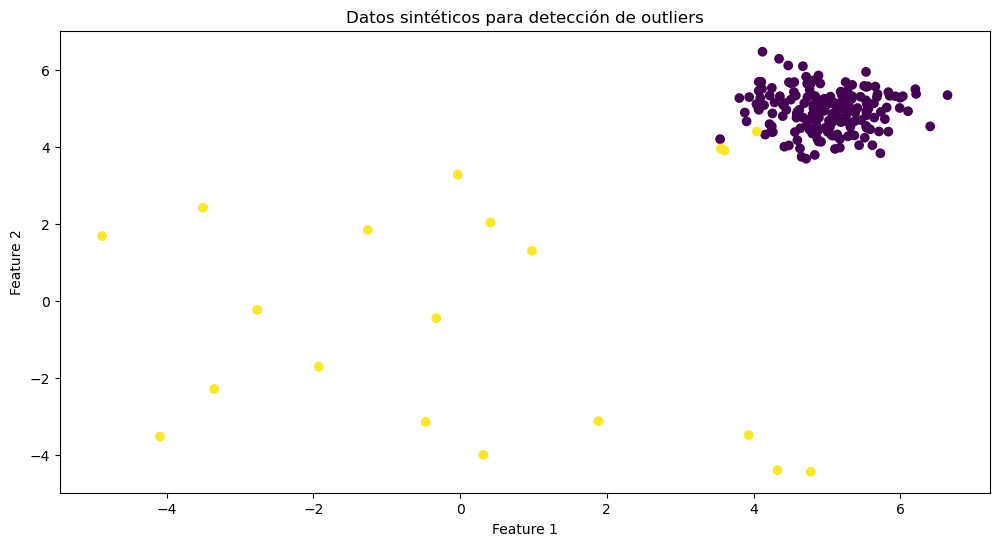

In [13]:
import pyod

contamination = 0.1  # percentage of outliers
n_train = 200  # number of training points
n_test = 100  # number of testing points

X_train, X_test, y_train, y_test = pyod.utils.data.generate_data(
    n_train=n_train, n_test=n_test, contamination=contamination)

#vamos a pintar los datos
plt.figure(figsize=(12, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis')
plt.title("Datos sintéticos para detección de outliers")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


1. Se propone aplicar diferentes modelos de detección de outliers (https://pyod.readthedocs.io/en/latest/pyod.html) para ver su efectividad. 
2. Se propone usar data sets de benchmarking para realizar alguna detección de outliers jugando con los thresholds (https://pyod.readthedocs.io/en/latest/benchmark.html)